In [21]:
import os
import glob
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
data_dir = "./LibriSpeech"
out_dir = "./data"
os.makedirs(out_dir, exist_ok=True)
subset = "dev-clean"

In [23]:
metadata_path =os.path.join(data_dir, "SPEAKERS.TXT")
metadata = open(metadata_path).readlines()
header = [h.replace(';', '').strip().lower() for h in metadata[11].split("|")]

metadata_df = []
for i in range(12, len(metadata)):
    d = [item.strip() for item in metadata[i].split("|")]
    id = d[0]
    gender = d[1]
    sub = d[2]
    minutes = d[3]
    name = " ".join(d[4:])
    metadata_df.append([id, gender, sub, minutes, name])

metadata_df = pd.DataFrame(metadata_df, columns=header, index=None)
metadata_df = metadata_df[metadata_df["subset"] == subset]
metadata_df = metadata_df.reset_index(drop=True)
print(metadata_df.head())

    id sex     subset minutes             name
0   84   F  dev-clean    8.02   Christie Nowak
1  174   M  dev-clean    8.04    Peter Eastman
2  251   M  dev-clean    8.04      Mark Nelson
3  422   M  dev-clean    8.38  President Lethe
4  652   M  dev-clean    8.31     Scott Walter


In [24]:
subjects = glob.glob(data_dir + f"/{subset}/*")

data_df = []
for subject_path in sorted(subjects, key=lambda x: int(x.split("/")[-1])):
    speaker_id = subject_path.split("/")[-1]
    
    for chapter_path in sorted(glob.glob(subject_path + "/*"), key=lambda x: int(x.split("/")[-1])):
        chapter_id = chapter_path.split("/")[-1]
        
        corpus_path = os.path.join(chapter_path, f"{speaker_id}-{chapter_id}.trans.txt")
        assert os.path.exists(corpus_path)
        
        with open(corpus_path) as f:
            corpus = f.readlines()
        
        corpus = [c.strip().split() for c in corpus]
        corpus_df = {c[0]: " ".join(c[1:]) for c in corpus}
        corpus_df = pd.DataFrame(corpus_df.items(), columns=["audio_id", "transcript"])
        
        audio_paths = sorted(glob.glob(chapter_path + "/*.flac"))
        for audio_path in audio_paths:
            audio_id = audio_path.split("/")[-1].split(".")[0]
            transcript = corpus_df[corpus_df["audio_id"] == audio_id]['transcript'].values[0]
            
            data_df.append({
                "speaker_id": speaker_id,
                "chapter_id": chapter_id,
                "audio_id": audio_id,
                "audio_path": audio_path.replace(data_dir + '/', ''),
                "transcript": transcript
            })

data_df = pd.DataFrame(data_df)
data_df = pd.merge(data_df, metadata_df, left_on="speaker_id", right_on="id")
data_df = data_df.drop(columns=["id"])

out_path = f"{out_dir}/info.csv"
if not os.path.exists(out_path):
    data_df.to_csv(out_path, index=False)
else:
    print("info.csv already exists")
    data_df = pd.read_csv(out_path)

info.csv already exists


MFCC Example:

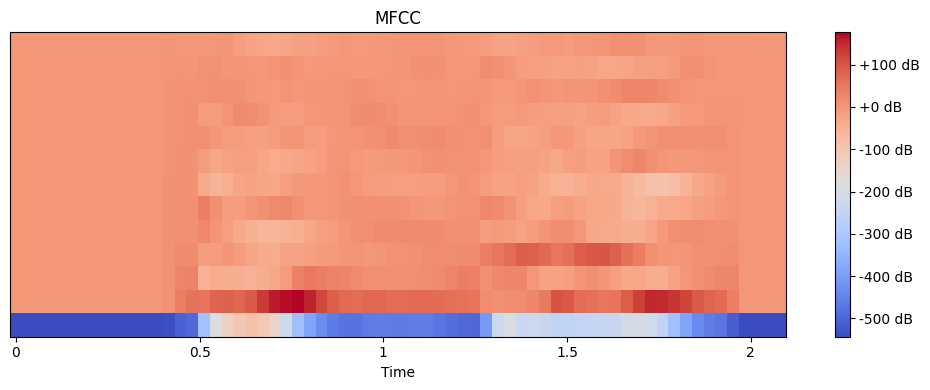

In [25]:
# Load the audio file
audio_file = os.path.join(data_dir, data_df['audio_path'][0])
y, sr = librosa.load(audio_file, sr=16000) # the audio file is sampled at 16 kHz

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 is the typical number of coefficients

# Display the MFCCs as a heatmap
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

#### Cross-Subject split

In [26]:
# train_test_split = 0.8

# random.seed(0)
# all_subjects = male_df['speaker_id'].unique().tolist() + female_df['speaker_id'].unique().tolist()
# random.shuffle(all_subjects)

# all_train_subjects = all_subjects[:int(train_test_split * len(all_subjects))]
# # further split to train and validation
# train_subjects = all_train_subjects[:int(train_test_split * len(all_train_subjects))]
# val_subjects = all_train_subjects[int(train_test_split * len(all_train_subjects)):]
# test_subjects = all_subjects[int(train_test_split * len(all_subjects)):]

In [27]:
# metadata_path = "../data/metadata.json"

# if not os.path.exists(metadata_path):
#     metadata = {
#         "train": train_subjects,
#         "val": val_subjects,
#         "test": test_subjects,
#     }

#     with open(metadata_path, "w") as f:
#         json.dump(metadata, f, indent=4)

# else:
#     print("metadata.json already exists")
#     with open (metadata_path, "r") as f:
#         metadata = json.load(f)

In [28]:
# train_df = data_df[data_df['speaker_id'].isin(train_subjects)]
# val_df = data_df[data_df['speaker_id'].isin(val_subjects)]
# test_df = data_df[data_df['speaker_id'].isin(test_subjects)]

# print("Number of train subjects: {} | # male: {} | # female: {}".format(len(train_subjects), len(train_df[train_df['sex'] == 'M']['speaker_id'].unique()), len(train_df[train_df['sex'] == 'F']['speaker_id'].unique())))
# print("Number of validation subjects: {} | # male: {} | # female: {}".format(len(val_subjects), len(val_df[val_df['sex'] == 'M']['speaker_id'].unique()), len(val_df[val_df['sex'] == 'F']['speaker_id'].unique())))
# print("Number of test subjects: {} | # male: {} | # female: {}".format(len(test_subjects), len(test_df[test_df['sex'] == 'M']['speaker_id'].unique()), len(test_df[test_df['sex'] == 'F']['speaker_id'].unique())))